In [1]:
import nideconv
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

reg = re.compile('.*/(?P<ds>ds-[0-9]+)/sub-(?P<subject>[0-9]+)_run-(?P<run>[0-9]+).csv')
fns = glob.glob('./extracted_signals/ds-*/sub-*.csv')

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling 

In [2]:
df = []

for fn in fns:
    
    if reg.match(fn):
    
        d = pd.read_csv(fn, index_col=0)#.to_frame('signal')
        meta = reg.match(fn).groupdict()

        for key in meta:
            d[key] = meta[key]

        d.index.name = 't'
        d.reset_index()
        d['subject'] = d.apply(lambda row: '{subject}'.format(**row.to_dict()), 1)
        
        
#        d['mask'] = d.apply(lambda row: '{mask}-{subroi}'.format(**row.to_dict()), 1)
#         d.drop('ds', 1, inplace=True)
        df.append(d)
    
df = pd.concat(df).reset_index()
df['subject'] = df['subject'].astype(int)
df.loc[df['ds']=='ds-02', 'subject'] += df.loc[df['ds']=='ds-01', 'subject'].max()
df['run'] = df['run'].astype(int)
del df['ds']
df = df.set_index(['subject', 'run', 't']).sort_values(['subject', 'run', 't'])
df.head()

rM1       lM1
subject run t                     
1       1   0  -1.563824 -0.800427
            3  -2.751460 -2.270995
            6  -3.031276 -2.449642
            9  -2.854485 -2.380471
            12 -2.547680 -2.040830

In [3]:
reg = re.compile('.*/(?P<ds>ds-[0-9]+)/.*/sub-(?P<subject>[0-9]+)_task-randomdotmotion_run-(?P<run>[0-9]+)_events.tsv')

In [4]:
## get events
behavior = pd.read_pickle('./derivatives/behavior.pkl')
behavior['sub'] = behavior['subject']
behavior.loc[behavior['ds']=='ds-02', 'sub'] = behavior.loc[behavior['ds']=='ds-02', 'sub'].astype(int) + behavior.loc[behavior['ds']=='ds-01', 'sub'].astype(int).max()
behavior['sub'] = behavior['sub'].astype(int)
behavior['onset_response'] = behavior['onset_stim'] + behavior['rt']/1000
behavior = behavior.loc[behavior.response.isin([1,2])]  # remove errors

events_cue = behavior[['sub', 'block', 'cue', 'onset_cue']]
events_cue['event_type'] = events_cue['cue'].apply(lambda x: 'cue_' + x)
events_cue = events_cue.rename(columns={'block': 'run', 'onset_cue': 'onset'})

events_stim = behavior[['sub', 'block', 'difficulty', 'onset_stim']]
events_stim = events_stim.rename(columns={'block': 'run', 'onset_stim': 'onset', 'difficulty': 'event_type'})

events_responses = behavior[['sub', 'block', 'response', 'onset_response']]
events_responses['event_type'] = events_responses['response'].replace({1: 'response_left', 2: 'response_right', -1: 'error'})
events_responses = events_responses.rename(columns={'block': 'run', 'onset_response': 'onset'})

events = pd.concat((events_cue, events_stim, events_responses))
events = events.sort_values(by=['sub', 'run', 'onset'])
events = events.rename(columns={'sub': 'subject'})

events = events.set_index(['subject', 'run'])[['onset', 'event_type']]#.rename(columns={'event_type': 'trial_type'})
events['duration'] = 0.001
events.head()

# ## correct onsets due to STC
events['onset'] -= 1.5
events.head()

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



onset     event_type  duration
subject run                                 
1       1     6.000       cue_left     0.001
        1     8.750           easy     0.001
        1     9.821  response_left     0.001
        1    15.000       cue_left     0.001
        1    17.750           hard     0.001

In [5]:
## get confounds
all_csvs = glob.glob('./derivatives/ds-*/fmriprep_confounds/sub-*_task-randomdotmotion_run-*_desc-confounds_regressors.tsv')

reg = re.compile('.*ds-(?P<ds>\d+)/fmriprep_confounds/sub-(?P<sub>\d+)_.*_run-(?P<run>\d+)_.*')
reg.match(all_csvs[1]).groupdict()


confounds_df = []

# loop over .csv-files, adding signal row-by-row
for fn in all_csvs:
    d = reg.match(fn).groupdict()
    tmp = pd.read_csv(fn, sep='\t')
    tmp['sub'] = d['sub']
    tmp['run'] = d['run']
    tmp['ds'] = d['ds']
    confounds_df.append(tmp)

confounds_df = pd.concat(confounds_df, axis=0)
confounds_df['ds'] = confounds_df['ds'].astype(int)
confounds_df['run'] = confounds_df['run'].astype(int)
confounds_df['subject'] = confounds_df['sub'].astype(int)

# adjust ds2 subject idx to ensure non-overlapping subject idx
max_sub_ds1 = confounds_df.loc[confounds_df.ds==1,'subject'].max()
confounds_df.loc[confounds_df.ds==2,'subject'] = confounds_df.loc[confounds_df.ds==2,'subject']+max_sub_ds1
confounds_df = confounds_df.sort_values(['ds', 'subject', 'run']).set_index(['ds', 'subject', 'run'])

# Include confounds: 5 ACompCor regressors, cosines for drift, DVARS, rotation & translation params
confounds_deconv = confounds_df.reset_index(level=0, drop=True)
include_confounds = ['a_comp_cor_0' + str(x) for x in range(5)] + ['cosine' + str(x).zfill(2) for x in range(17)]
include_confounds = include_confounds + ['dvars', 'framewise_displacement']
include_confounds = include_confounds + ['rot_' + a for a in ['x', 'y', 'z']]
include_confounds = include_confounds + ['trans_' + a for a in ['x', 'y', 'z']]
confounds_deconv = confounds_deconv[include_confounds]
confounds_deconv.head()

<>:4: DeprecationWarning: invalid escape sequence \d
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



a_comp_cor_00  a_comp_cor_01  a_comp_cor_02  a_comp_cor_03  \
subject run                                                               
1       1        -0.076368      -0.024852       0.008989      -0.092645   
        1        -0.154372       0.013430      -0.084220       0.008871   
        1        -0.139079       0.046189      -0.037292       0.061723   
        1        -0.074539       0.044704       0.000576       0.052884   
        1        -0.006416       0.021674       0.051981       0.045026   

             a_comp_cor_04  cosine00  cosine01  cosine02  cosine03  cosine04  \
subject run                                                                    
1       1         0.145740  0.071888  0.071886  0.071883  0.071879  0.071874   
        1         0.135120  0.071883  0.071867  0.071841  0.071803  0.071755   
        1         0.092630  0.071874  0.071829  0.071755  0.071652  0.071519   
        1         0.022459  0.071860  0.071772  0.071628  0.071425  0.071164   
        1        -0.017255  0.071841  0.071697  0.071457  0.071122  0.070693   

             ...  cosine15  cosine16      dvars  framewise_displacement  \
subject run  ...                                                          
1       1    ...  0.071737  0.071717        NaN                     NaN   
        1    ...  0.070528  0.070354  29.534298                0.106529   
        1    ...  0.068132  0.067652  22.207958                0.055383   
        1    ...  0.064587  0.063665  19.671873                0.040175   
        1    ...  0.059955  0.058466  19.645233                0.054571   

                rot_x     rot_y     rot_z   trans_x   trans_y   trans_z  
subject run                                                              
1       1    0.001524  0.000356 -0.000161 -0.082265 -0.115355  0.062333  
        1    0.000932  0.000164  0.000000 -0.070083 -0.092359  0.086446  
        1    0.000673  0.000346 -0.000137 -0.065494 -0.095517  0.105258  
        1    0.000511  0.000322 -0.000230 -0.059378 -0.081704  0.098941  
        1    0.000099  0.000239 -0.000194 -0.051345 -0.065291  0.095407  

[5 rows x 30 columns]

## Responses left/right

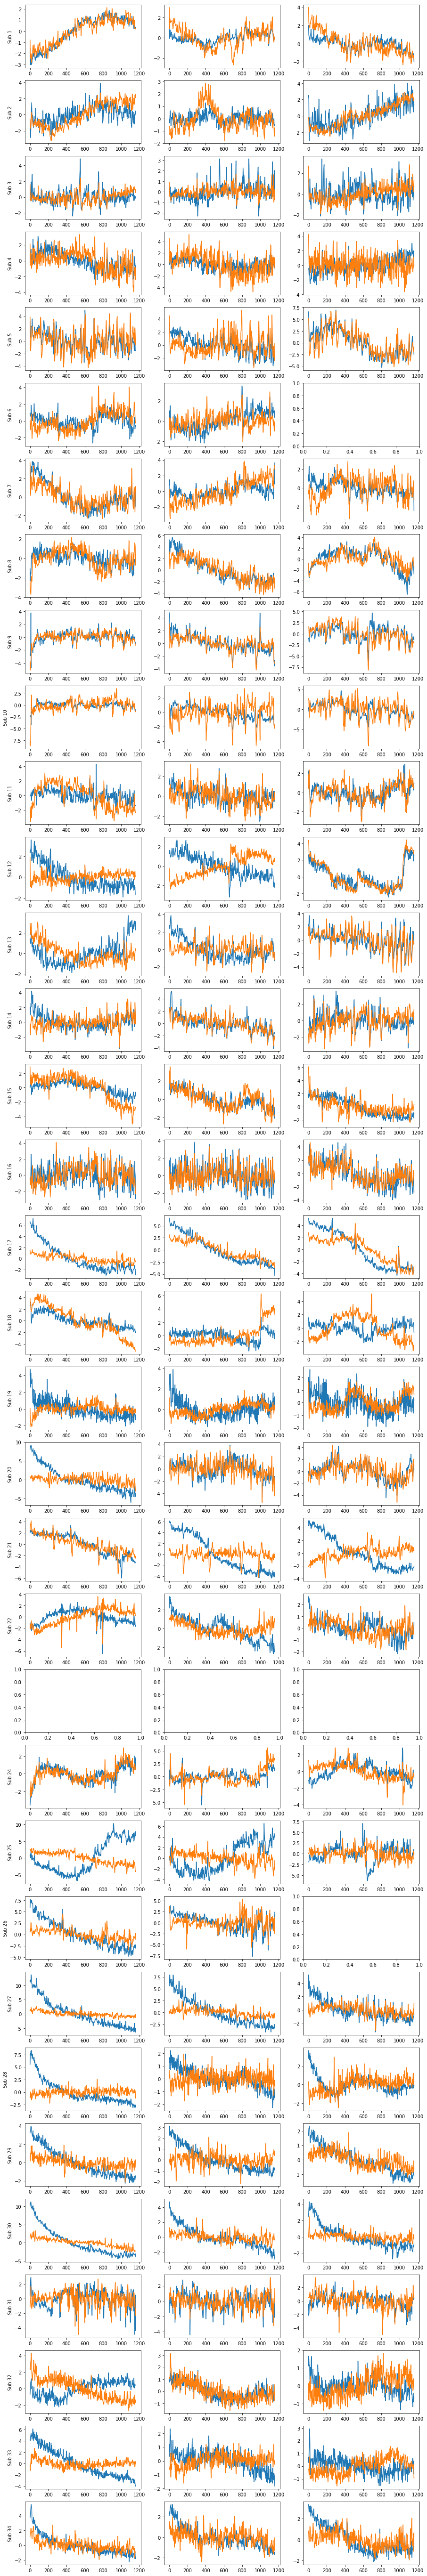

In [6]:
f, ax = plt.subplots(34, 3)
for sub in df.reset_index()['subject'].unique():
    for run in df.loc[sub].reset_index()['run'].unique():
        ax[sub-1,run-1].plot(df.loc[sub, run])
    ax[sub-1,0].set_ylabel('Sub {}'.format(sub))
    
f.set_size_inches(15, 100)

## Deconvolve overall, include cue and stim in model

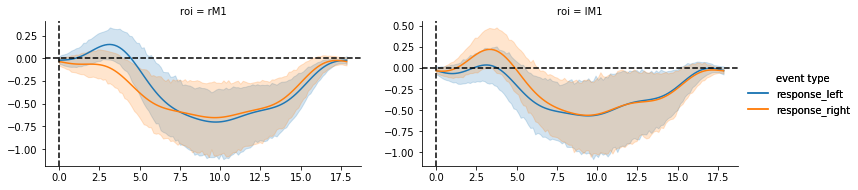

In [42]:
events_ = events.copy()
events_.loc[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral']), 'event_type'] = 'cue'
events_.loc[events_['event_type'].isin(['easy', 'hard']), 'event_type'] = 'stim'
#events_ = events_[events_['event_type'].isin(['response_left', 'response_right'])]
del events_['duration']

gf = nideconv.GroupResponseFitter(df, events_, 1/3., confounds=confounds_deconv.fillna(0))
gf.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('stim', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['response_left', 'response_right'],
                              ci=95, plots='covariate', col='roi', col_wrap=2)

## exclude cue & stim from model

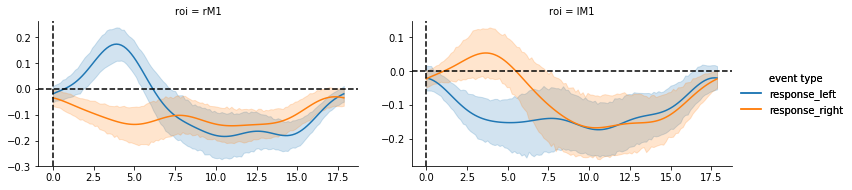

In [43]:
events_ = events.copy()
#events_.loc[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral']), 'event_type'] = 'cue'
#events_.loc[events_['event_type'].isin(['easy', 'hard']), 'event_type'] = 'stim'
events_ = events_[events_['event_type'].isin(['response_left', 'response_right'])]
del events_['duration']

gf = nideconv.GroupResponseFitter(df, events_, 1/3., confounds=confounds_deconv.fillna(0))
#gf.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=9)
#gf.add_event('stim', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['response_left', 'response_right'],
                              ci=95, plots='covariate', col='roi', col_wrap=2)

## Leipzig

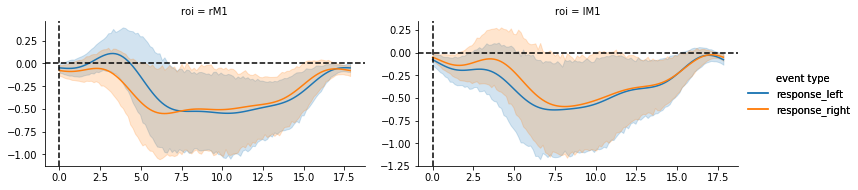

In [44]:
events_ = events.copy().loc[:19]
events_.loc[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral']), 'event_type'] = 'cue'
events_.loc[events_['event_type'].isin(['easy', 'hard']), 'event_type'] = 'stim'
del events_['duration']
df_ = df.loc[:19]
confounds_ = confounds_deconv.copy().loc[:19]

gfL1 = nideconv.GroupResponseFitter(df_, events_, 1/3., confounds=confounds_.fillna(0).reset_index(), 
                                  oversample_design_matrix=20)
gfL1.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfL1.add_event('stim', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfL1.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfL1.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)

gfL1.fit()
gfL1.plot_groupwise_timecourses(event_types=['response_left', 'response_right'], #, 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)

Without stims & cues

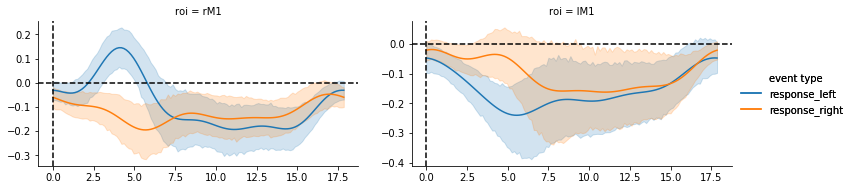

In [45]:
events_ = events.copy().loc[:19]
events_ = events_[events_['event_type'].isin(['response_left', 'response_right'])]
del events_['duration']
df_ = df.loc[:19]
confounds_ = confounds_deconv.copy().loc[:19]

gfL2 = nideconv.GroupResponseFitter(df_, events_, 1/3., confounds=confounds_.fillna(0).reset_index(), 
                                  oversample_design_matrix=20)
gfL2.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfL2.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)

gfL2.fit()
gfL2.plot_groupwise_timecourses(event_types=['response_left', 'response_right'], #, 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)

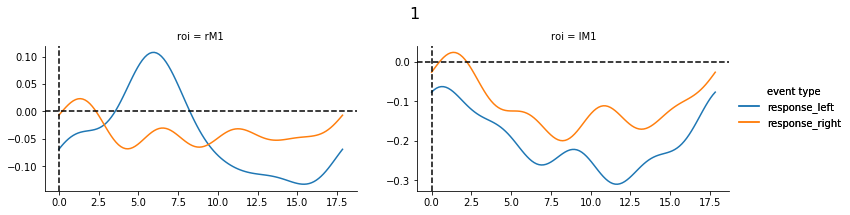

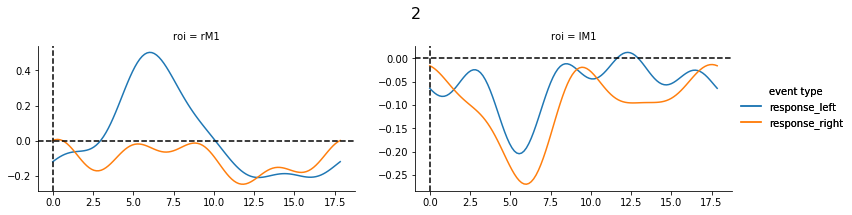

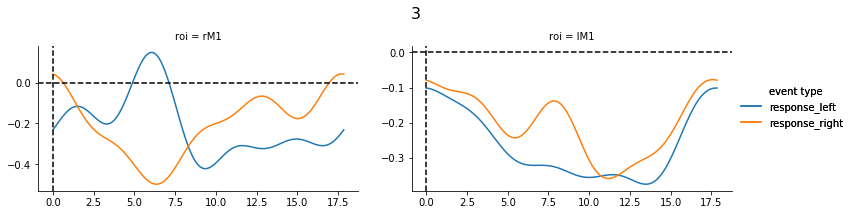

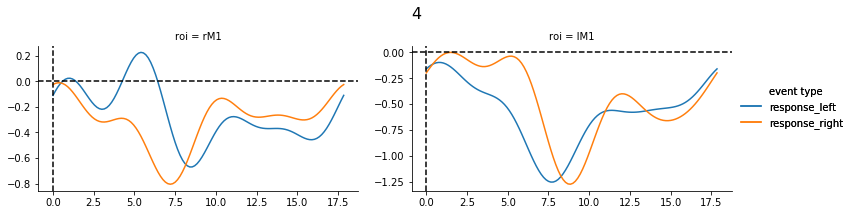

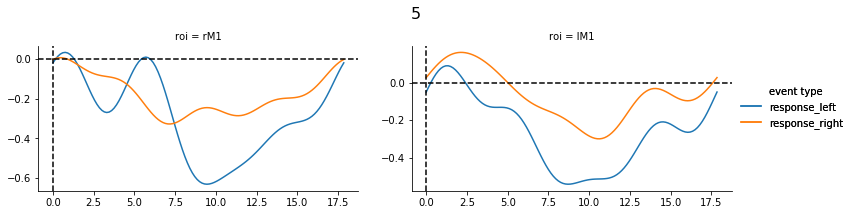

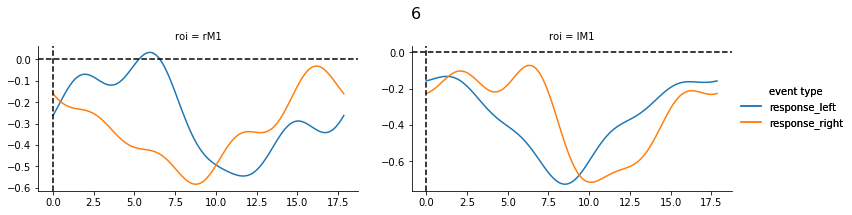

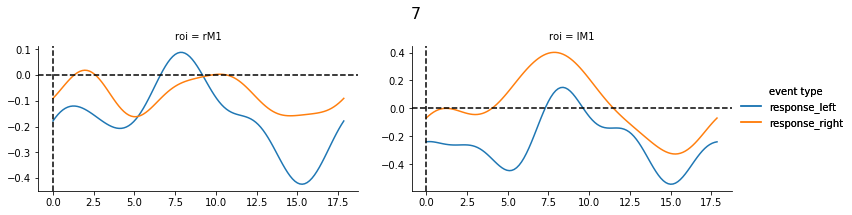

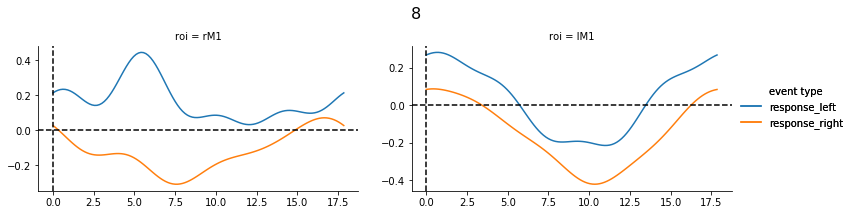

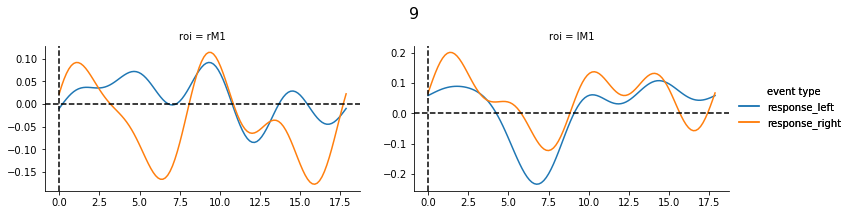

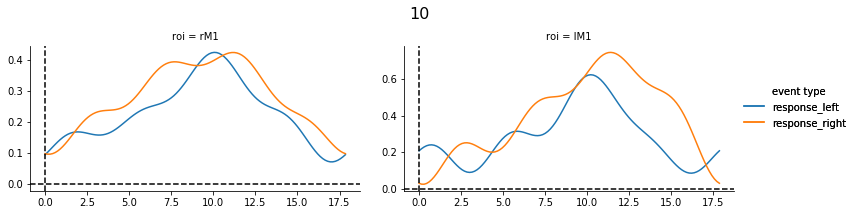

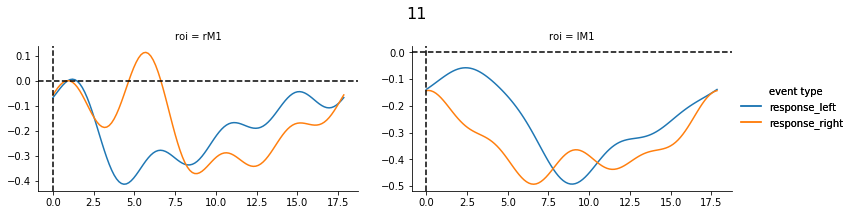

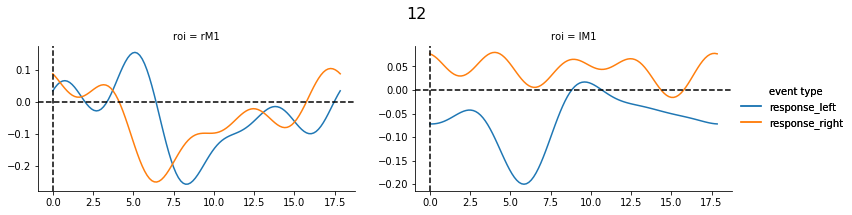

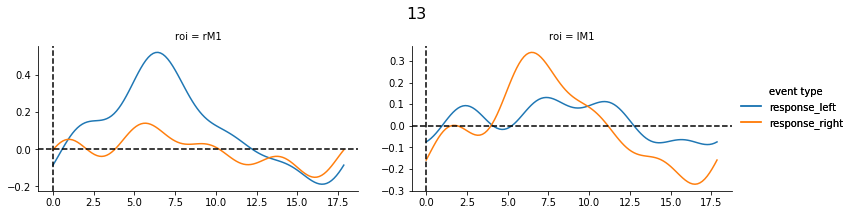

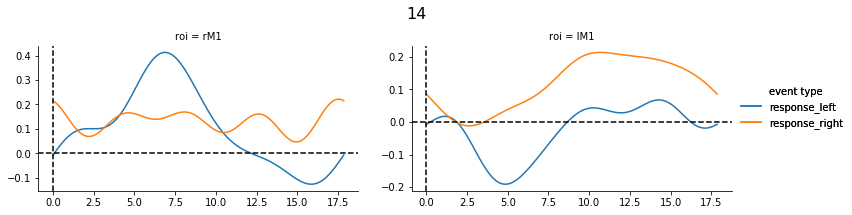

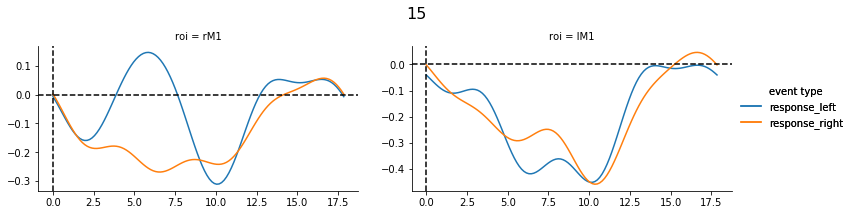

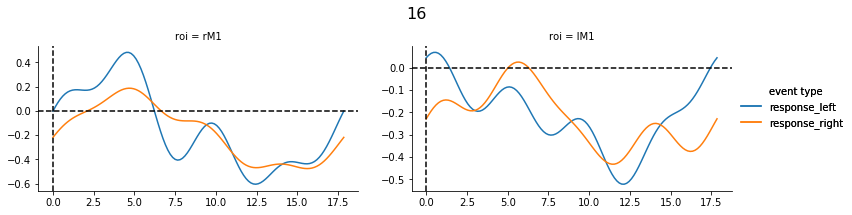

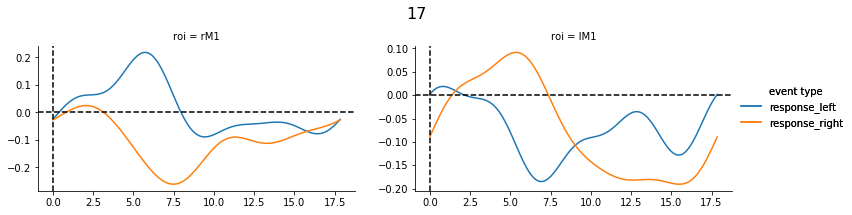

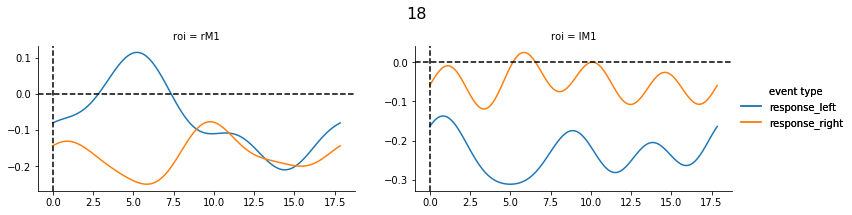

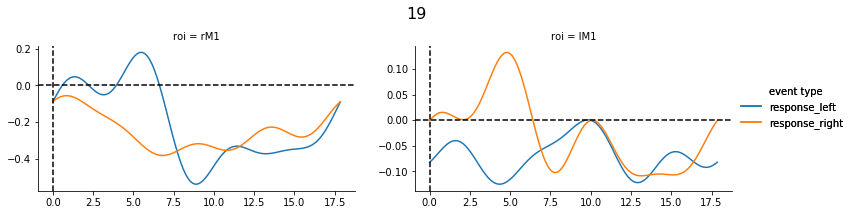

In [36]:
gfL2.plot_subject_timecourses(event_types=['response_left', 'response_right'], row=None, col='roi', plots='subject', col_wrap=None)

## Amsterdam

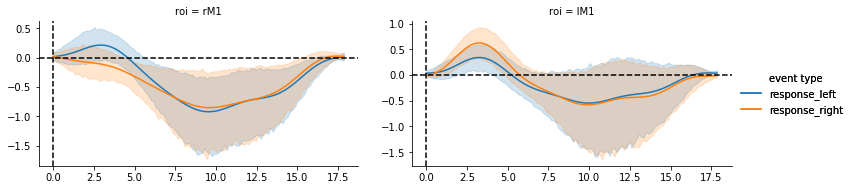

In [46]:
events_ = events.copy().loc[20:]
events_.loc[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral']), 'event_type'] = 'cue'
events_.loc[events_['event_type'].isin(['easy', 'hard']), 'event_type'] = 'stim'
#events_ = events_[events_['event_type'].isin(['response_left', 'response_right'])]
del events_['duration']
df_ = df.loc[20:]
confounds_ = confounds_deconv.copy().loc[20:] #.reset_index()

gfA1 = nideconv.GroupResponseFitter(df_, events_, 1/3., confounds=confounds_.fillna(0).reset_index(), 
                                    oversample_design_matrix=20)
gfA1.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfA1.add_event('stim', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfA1.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfA1.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)

gfA1.fit()
gfA1.plot_groupwise_timecourses(event_types=['response_left', 'response_right'], #, 'stim', 'cue'],
                              ci=95, plots='covariate', col='roi', col_wrap=2)

Without stims & cue

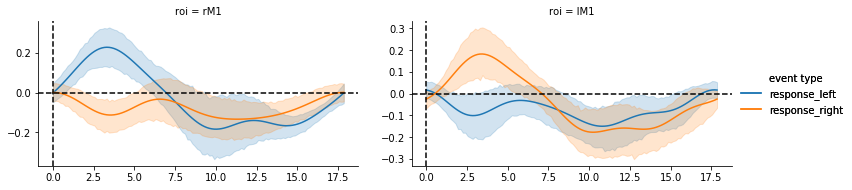

In [47]:
events_ = events.copy().loc[20:]
events_ = events_[events_['event_type'].isin(['response_left', 'response_right'])]
del events_['duration']
df_ = df.loc[20:]
confounds_ = confounds_deconv.copy().loc[20:] #.reset_index()

gfA2 = nideconv.GroupResponseFitter(df_, events_, 1/3., confounds=confounds_.fillna(0).reset_index(), 
                                    oversample_design_matrix=20)
gfA2.add_event('response_left', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfA2.add_event('response_right', interval=[0, 18], basis_set='fourier', n_regressors=9)

gfA2.fit()
gfA2.plot_groupwise_timecourses(event_types=['response_left', 'response_right'], #, 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)  

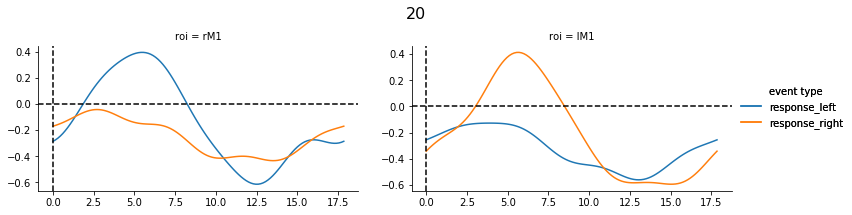

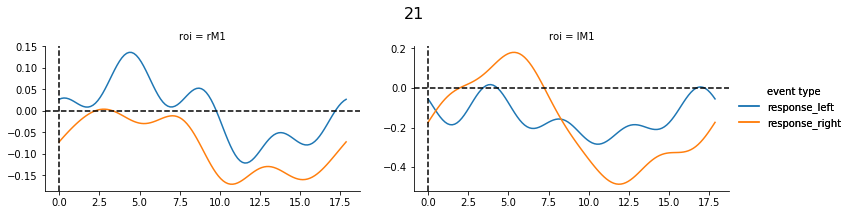

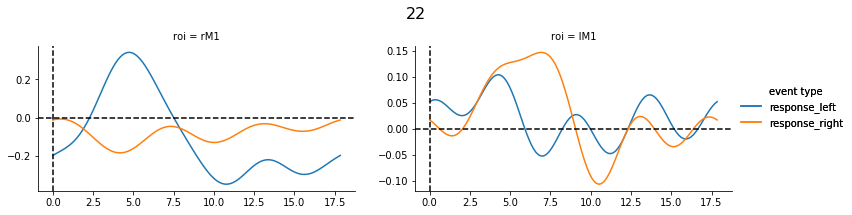

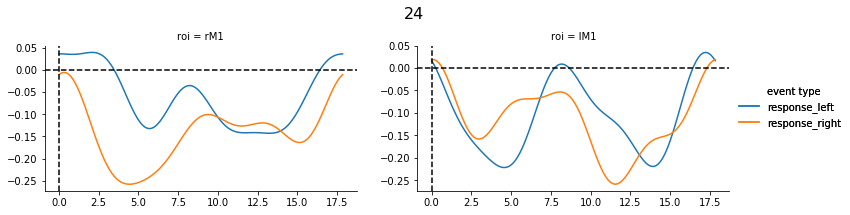

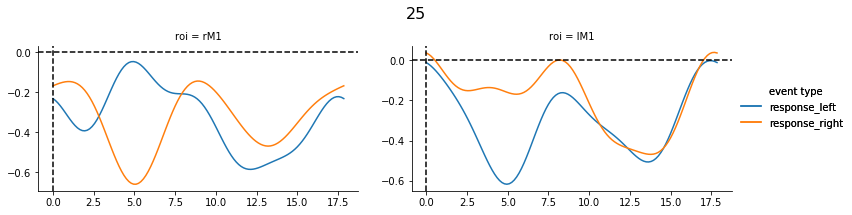

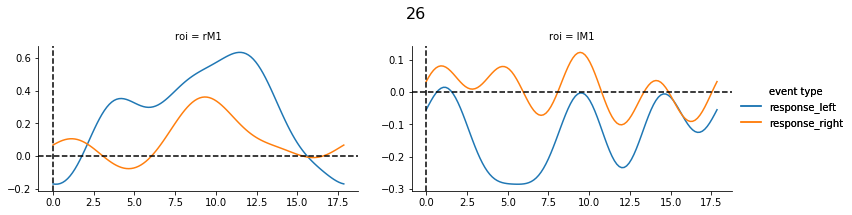

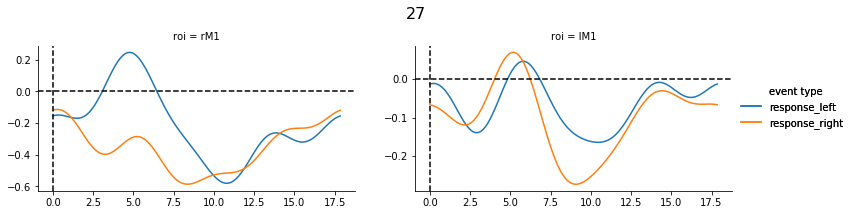

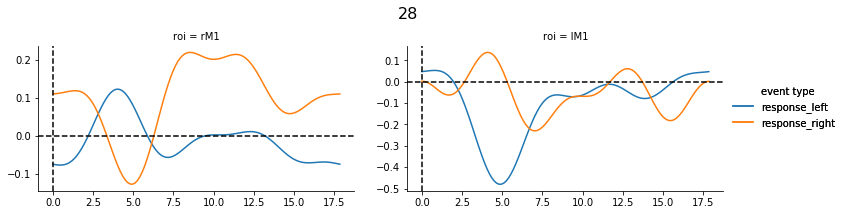

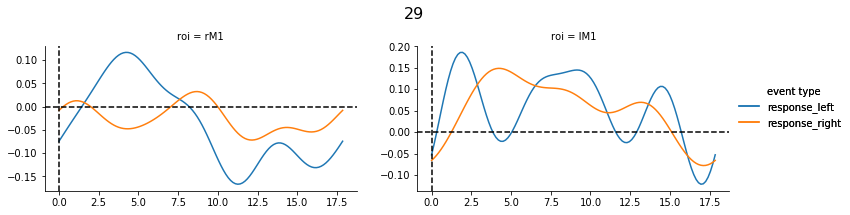

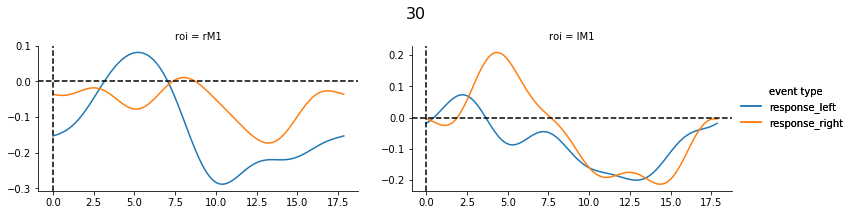

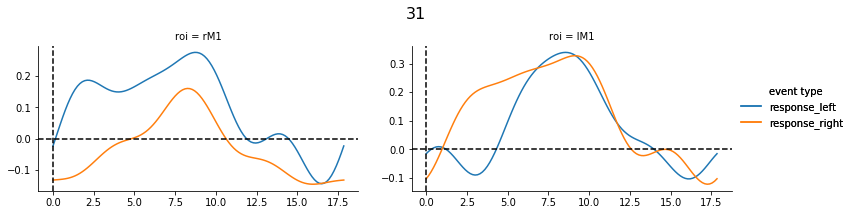

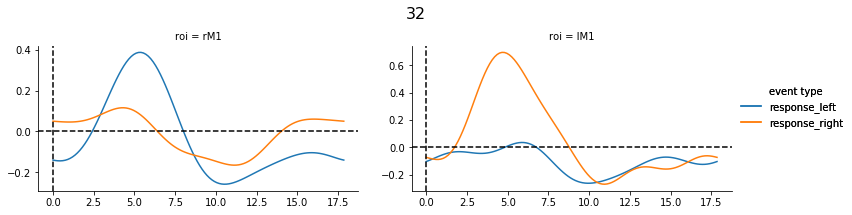

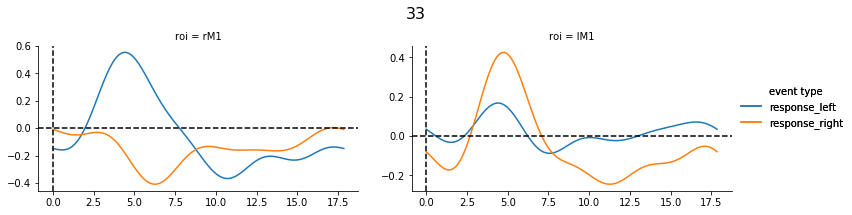

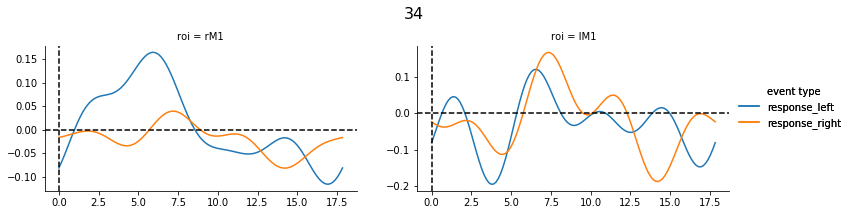

In [39]:
gfA2.plot_subject_timecourses(event_types=['response_left', 'response_right'], row=None, col='roi', plots='subject', col_wrap=None)

Here, the Amsterdam data looks cleaner. Both data sets show the left/right contrast, but there appears to be some sort of negative "bump" in lM1 in the Leipzig data that "pulls" the signal down from baseline.

## sigma2?

In [40]:
sigma2s_ds1 = gfL1._get_response_fitters().apply(lambda x: x.sigma2)
sigma2s_ds2 = gfA1._get_response_fitters().apply(lambda x: x.sigma2)

In [41]:
display(sigma2s_ds1)
display(sigma2s_ds2)

print(sigma2s_ds1.mean(0))
print(sigma2s_ds2.mean(0))

,rM1,lM1
subject,,
1,0.397605,0.762270
2,0.504360,0.295194
3,0.553624,0.206958
4,0.633557,1.215894
5,1.039747,1.579478
6,0.325622,0.354480
7,0.569716,0.899878
8,0.958027,0.988148
9,0.889305,0.906224


,rM1,lM1
subject,,
20,2.133913,0.914914
21,0.451132,1.010735
22,0.500954,0.535358
24,0.380741,0.454112
25,1.277306,0.740960
26,1.423752,1.167167
27,1.734753,0.264572
28,0.752033,0.306724
29,0.145893,0.214641


rM1    0.544918
lM1    0.795377
dtype: float64
rM1    0.846559
lM1    0.549299
dtype: float64


In [17]:
sigma2s_ds1 = gfL2._get_response_fitters().apply(lambda x: x.sigma2)
sigma2s_ds2 = gfA2._get_response_fitters().apply(lambda x: x.sigma2)

In [18]:
display(sigma2s_ds1)
display(sigma2s_ds2)

print(sigma2s_ds1.mean(0))
print(sigma2s_ds2.mean(0))

,rM1,lM1
subject,,
1,0.392930,0.755547
2,0.502225,0.292483
3,0.553934,0.206570
4,0.636978,1.230565
5,1.028795,1.582113
6,0.327973,0.351943
7,0.560857,0.889623
8,0.954087,0.975352
9,0.883344,0.904116


,rM1,lM1
subject,,
20,2.112052,0.920016
21,0.447267,1.002985
22,0.495456,0.533485
24,0.379711,0.448976
25,1.277331,0.745744
26,1.429470,1.162165
27,1.714797,0.262794
28,0.743393,0.311330
29,0.145293,0.214643


rM1    0.543888
lM1    0.791770
dtype: float64
rM1    0.840796
lM1    0.548081
dtype: float64


## plot full model

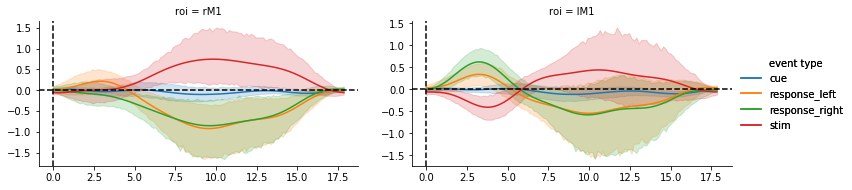

In [20]:
gfA1.plot_groupwise_timecourses(event_types=['response_left', 'response_right', 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)

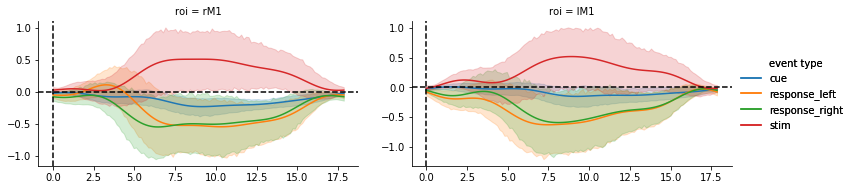

In [21]:
gfL1.plot_groupwise_timecourses(event_types=['response_left', 'response_right', 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)